In [1]:
!pip install luigi

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import urllib
import json
import luigi
import psycopg2

import pymongo
from pymongo import MongoClient, InsertOne

#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## Load data from URL and Save data into Mongodb

In [3]:
# load data from url and save it into json variable 
url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.json"
response = urllib.request.urlopen(url)

In [4]:
# load data into json dict
data = json.loads(response.read())
response.close()

In [5]:
# setting mongodb client
client = pymongo.MongoClient("mongodb://localhost:27017")
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [489]:
# Create database and collection if they are not exist to save data
db_name = 'Crash_db'
collection_name = 'Crash_collection'
if db_name in client.list_database_names():
    print(f"databaes {db_name} is exist.")
else: 
    db = client[db_name]
    if collection_name in client.db.list_collection_names():
        print(f"Collection {collection_name} is exist.")
    else :
        collection = db[collection_name]

In [491]:
df_columns = pd.DataFrame(data["meta"]["view"]["columns"])
columns = df_columns['fieldName'].tolist()
df_data = pd.DataFrame(data["data"], columns = columns)

# Convert dataset to dictionary
dict_data = df_data.to_dict(orient="records")
# insert data into mongo db
db[collection_name].insert_many(dict_data)

In [7]:
# create a class to run luigi task and run the pipeline 
class LoadFromMongodb(luigi.Task):
    """
    A Luigi task to write a json file into mongodb
    """
    client = luigi.Parameter()
    database = luigi.Parameter()
    collection = luigi.Parameter()
    path = luigi.Parameter()

    def output(self):
        """
        Returns the target output for this task. 

        """
        return luigi.LocalTarget(self.path)

    def run(self):
        """
        Contains the logic of the Task, 
        """
        # setting mongodb client
        client = pymongo.MongoClient(self.client)
        db = client[self.database]
        collection = db[self.collection]
        
        # load data from mongo db and save into dataframe
        loaded_data = collection.find()
        df = pd.DataFrame(loaded_data)
        df.drop(['_id'], axis = 1, inplace = True)
        with self.output().open("w") as f:
            f.write(df.to_csv(index = False))

In [8]:
luigi.build([LoadFromMongodb(client="mongodb://localhost:27017", database="Crash_db", collection = "Crash_collection",
                             path = "D://NCI//database//dataset//Motor_Vehicle_Collisions_-_Crashes.csv")], workers=1, local_scheduler=True)

DEBUG: Checking if LoadFromMongodb(client=mongodb://localhost:27017, database=Crash_db, collection=Crash_collection, path=D://NCI//database//dataset//Motor_Vehicle_Collisions_-_Crashes.csv) is complete
INFO: Informed scheduler that task   LoadFromMongodb_mongodb___localh_Crash_collection_Crash_db_34d75d6831   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=7502544661, workers=1, host=LAPTOP-6RNKQLCL, username=SHERIN P MATHEW, pid=13920) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 LoadFromMongodb(client=mongodb://localhost:27017, database=Crash_db, collection=Crash_collection, path=D://NCI//database//dataset//Motor_Vehicle_Collisions_-_Crashes.csv)

Did not run any tasks
This progress looks :) because there were no

True

In [9]:
# load data
df= pd.read_csv("D://NCI//database//dataset//Motor_Vehicle_Collisions_-_Crashes.csv")

In [10]:
df.shape

(380464, 29)

In [11]:
df.head(10)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765.0,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547.0,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903.0,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314.0,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609.0,NaN,NaN,NaN,NaN,NaN
5,04/14/2021,12:47,NaN,NaN,NaN,NaN,NaN,MAJOR DEEGAN EXPRESSWAY RAMP,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4407458.0,Dump,Sedan,NaN,NaN,NaN
6,12/14/2021,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4486555.0,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
7,12/14/2021,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,Unspecified,NaN,NaN,NaN,4486660.0,Sedan,Sedan,NaN,NaN,NaN
8,12/14/2021,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,Unspecified,NaN,NaN,NaN,4487074.0,Sedan,NaN,NaN,NaN,NaN
9,12/14/2021,14:58,MANHATTAN,10017.0,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4486519.0,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


## Check Profile of data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380464 entries, 0 to 380463
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     380464 non-null  object 
 1   CRASH TIME                     380460 non-null  object 
 2   BOROUGH                        248657 non-null  object 
 3   ZIP CODE                       248609 non-null  float64
 4   LATITUDE                       349030 non-null  float64
 5   LONGITUDE                      349030 non-null  float64
 6   LOCATION                       349030 non-null  object 
 7   ON STREET NAME                 280969 non-null  object 
 8   CROSS STREET NAME              179860 non-null  object 
 9   OFF STREET NAME                99480 non-null   object 
 10  NUMBER OF PERSONS INJURED      380458 non-null  float64
 11  NUMBER OF PERSONS KILLED       380459 non-null  float64
 12  NUMBER OF PEDESTRIANS INJURED 

In [13]:
df.drop(['BOROUGH', 'LOCATION'], axis = 1, inplace = True)

In [435]:
# Join data and time columns and change it to datetime 
df['DateTime'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['DateTime']=df['DateTime'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [436]:
# extract time features
df['Year'] = df['DateTime'].dt.year
df['Month'] =  df['DateTime'].dt.month
df['Day'] =  df['DateTime'].dt.day
df['Hour'] =  df['DateTime'].dt.hour
df['Dayname']= df['DateTime'].dt.day_name()
df.drop('CRASH DATE', axis = 1, inplace = True)
df.drop('CRASH TIME' , axis = 1, inplace = True)
df.drop('DateTime', axis = 1, inplace = True)

In [14]:
# Prent percentage of missing values in each columns
df.isna().sum().sort_values(ascending = False) / df.shape[0]  * 100

VEHICLE TYPE CODE 5              99.319778
CONTRIBUTING FACTOR VEHICLE 5    99.295860
VEHICLE TYPE CODE 4              97.723306
CONTRIBUTING FACTOR VEHICLE 4    97.610549
VEHICLE TYPE CODE 3              91.458325
CONTRIBUTING FACTOR VEHICLE 3    90.887968
OFF STREET NAME                  73.852980
CROSS STREET NAME                52.726145
ZIP CODE                         34.656367
VEHICLE TYPE CODE 2              29.737373
ON STREET NAME                   26.150963
CONTRIBUTING FACTOR VEHICLE 2    20.952574
LATITUDE                          8.262017
LONGITUDE                         8.262017
VEHICLE TYPE CODE 1               1.015602
CONTRIBUTING FACTOR VEHICLE 1     0.457336
NUMBER OF PERSONS INJURED         0.001577
COLLISION_ID                      0.001314
NUMBER OF CYCLIST KILLED          0.001314
NUMBER OF MOTORIST KILLED         0.001314
NUMBER OF MOTORIST INJURED        0.001314
NUMBER OF CYCLIST INJURED         0.001314
NUMBER OF PEDESTRIANS KILLED      0.001314
NUMBER OF P

In [15]:
# droping missing values of columns that have less than 15% missing
for col in df.columns:
    if (df[col].isna().sum()/ df.shape[0]) < 0.15 :
        df.dropna(subset=[col], axis = 0 , inplace = True)

In [16]:
# count number of data in each rows of Vehicle type and save in new columns
cols = [x for x in df.columns if 'VEHICLE TYPE CODE' in x]
df['COUNT OF VEHICLE TYPE'] = df[cols].count(axis = 'columns')

In [17]:
# count number of data in each rows of Contributing factor and save in new columns
cols = [x for x in df.columns if 'CONTRIBUTING FACTOR VEHICLE' in x]
df['COUNT OF CONTRIBUTING'] = df[cols].count(axis = 'columns')

In [18]:
# Drop columns with more tha 90% missing
for col in df.columns :
    if (df[col].isna().sum()/ df.shape[0]) > 0.9 :
        df.drop(col, axis = 1, inplace = True)

In [19]:
# convert invalid data to nan 
df['OFF STREET NAME'].replace('                                        ', np.nan, inplace = True)
df['ON STREET NAME'].replace('                                ',np.nan, inplace = True)

In [20]:
# Check whether there is any record that both ON Street ad Off street have value
len(df[df['ON STREET NAME'].notna() & df['OFF STREET NAME'].notna()])

0

In [21]:
df['OFF STREET NAME'].fillna('', inplace = True)
df['ON STREET NAME'].fillna('', inplace = True)
df['STREET NAME'] = df['ON STREET NAME'] + df['OFF STREET NAME']

**As all remaiming missing values are categorical data then we will fill them with fix value**

In [22]:
df['COLLISION_ID'].nunique()

345014

**This is a uniqe column then we can drop it.**

In [23]:
df.drop(['COLLISION_ID'], axis = 1, inplace = True)

In [24]:
df.duplicated().sum()

119

In [25]:
# Delete duplicate values
df.drop_duplicates(inplace = True)

## Save clean data into SQL

In [482]:
conn = psycopg2.connect(database="postgres",
                        host="87.44.4.198",
                        user="data",
                        password="data",
                        port="5432")
conn.autocommit = True
cursor = conn.cursor()
# create database
query = '''CREATE database Crashes_db'''
try: 
    cursor.execute(query)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

In [483]:
# create table
conn = psycopg2.connect(database="Crashes_db",
                        host="87.44.4.198",
                        user="data",
                        password="data",
                        port="5432")
cursor = conn.cursor()

    
query ='''CREATE TABLE Crashes_tb(ZIP_CODE CHAR(10), LATITUDE FLOAT, LONGITUDE FLOAT,
        ON_STREET_NAME CHAR(50), CROSS_STREET_NAME CHAR(50), OFF_STREET_NAME CHAR(50), 
        NUMBER_PERSONS_INJURED FLOAT, NUMBER_PERSONS_KILLED FLOAT, NUMBER_PEDESTRIANS_INJURED  INT,
        NUMBER_PEDESTRIANS_KILLED   INT, NUMBER_CYCLIST_INJURED INT, NUMBER_CYCLIST_KILLED INT,
        NUMBER_MOTORIST_INJURED INT, NUMBER_MOTORIST_KILLED INT, CONTRIBUTING_FACTOR_1 CHAR(100),
        CONTRIBUTING_FACTOR_2 CHAR(100), VEHICLE_TYPE_1 CHAR(50), VEHICLE_TYPE_2 CHAR(50),
        Year INT, Month  INT, Day INT, Hour INT, Dayname CHAR(15),
        COUNT_VEHICLE_TYPE INT, COUNT_CONTRIBUTING INT, STREET_NAME CHAR(100))'''
try:
    cursor.execute(query)
    conn.commit()
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

In [ ]:
df.to_csv('clean_data.csv', index= False, header = False)

In [484]:
# Insert data into table
df.to_csv('clean_data.csv', index=False, header=False)
conn = psycopg2.connect(database="Crashes_db",
                        host="87.44.4.198",
                        user="data",
                        password="data",
                        port="5432")
cursor = conn.cursor()
query = '''COPY Crashes_tb FROM 'd:\clean_data.csv' CSV;'''
try:
    cursor.execute(query)
    conn.commit()
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

## Data Analysis

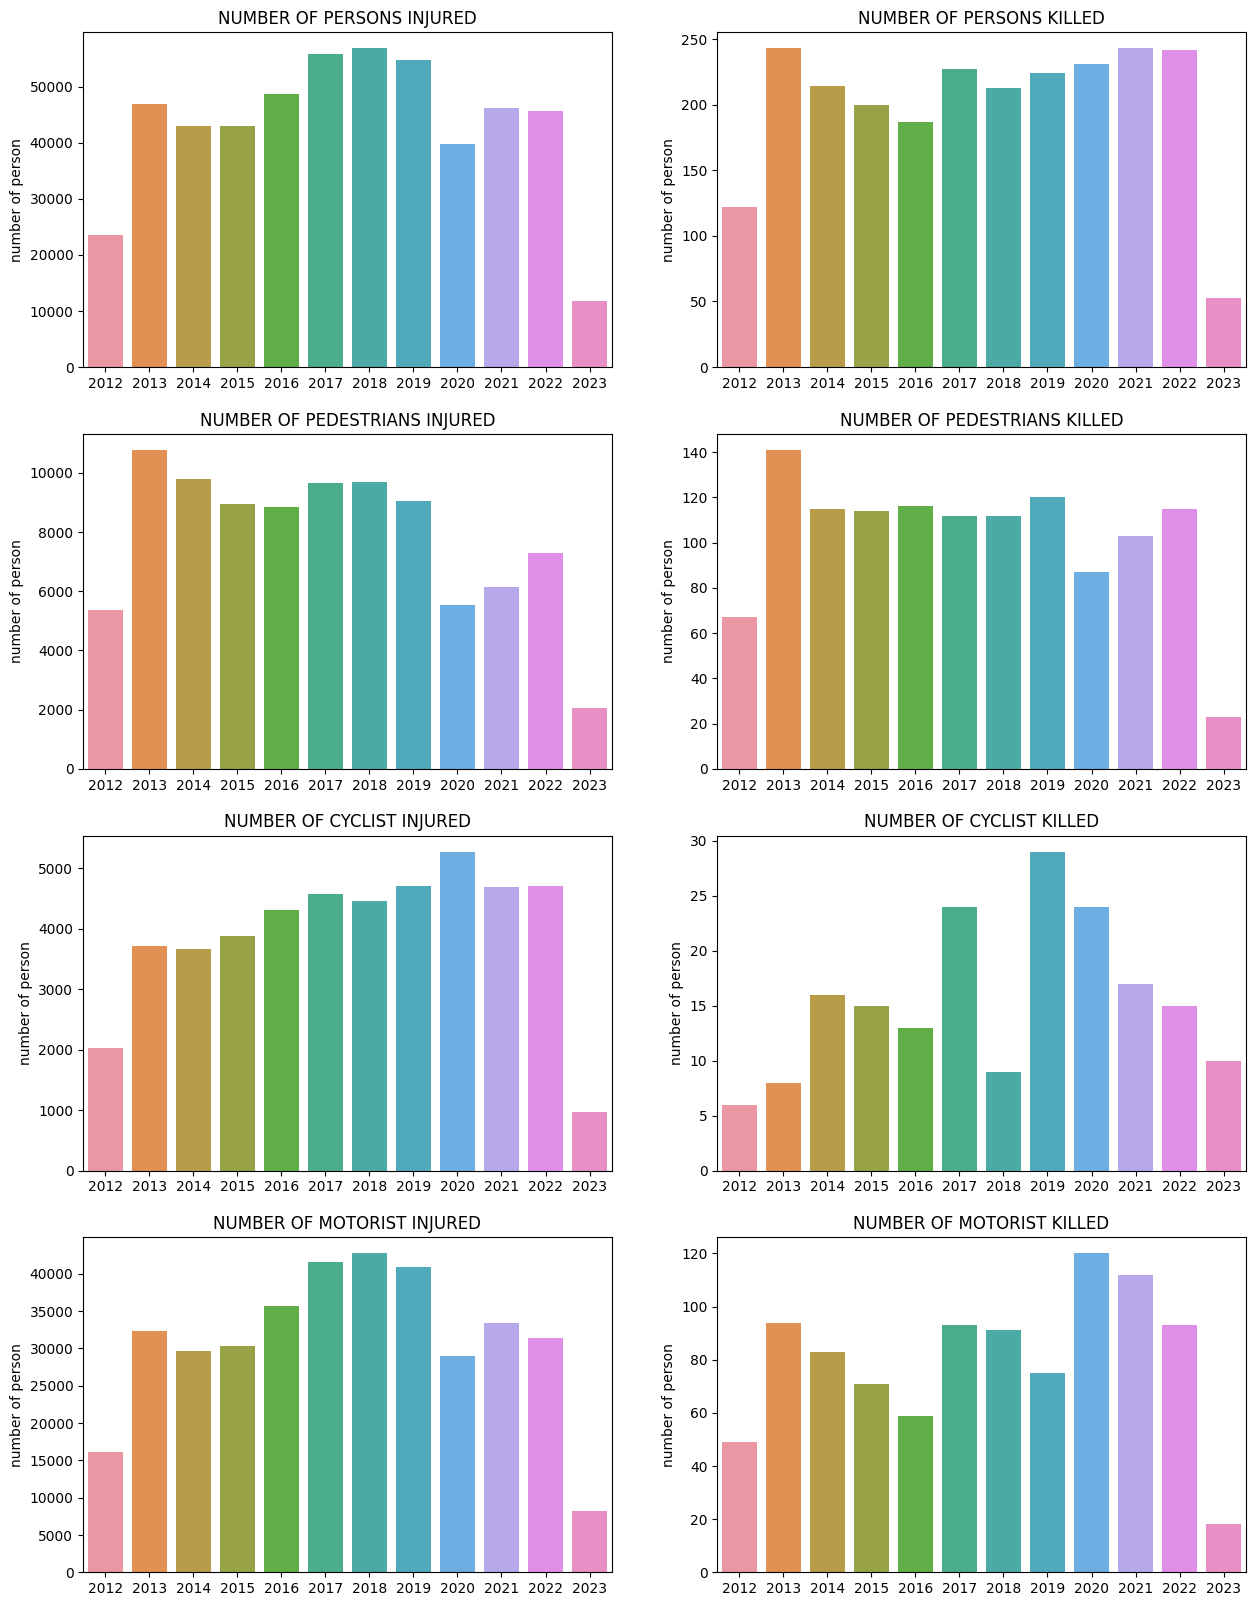

In [358]:
cols = [x for x in df.columns if 'NUMBER OF' in x]
i = 1
plt.figure(figsize=(15,20))
for col in cols :
    plt.subplot(4,2,i)
    data = df.groupby(['Year'])[col].sum()
    sns.barplot(x = data.index , y = data.values)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('number of person')
    i+=1
    

**Report**
- 2017-2019 had the highest number of injured person while in 2013, 2021 and 2022 there are the highest range of killed poeple
- number of killed people increase slightly from 2018 while the number of injured decreased. 
- The most injured and killed pedestrains are in 2013, after same trend from 2014 to 2019 the number of injured and killed perestrains increase every year after 2019
- number of killed cyclist decrease gradually from 2019 while the trend of injury is almost same
- the injured morotist had highst range in 2017 to 2019 and it is almost same on other years, but number of killed motorist decrease after a big jumped every 3 years and totaly it had a increasing trend


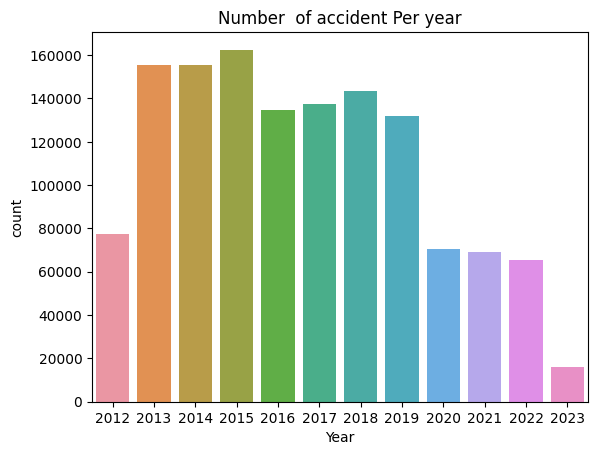

In [359]:
# Number of accident per year
data = df.groupby(['Year'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of accident Per year')
plt.ylabel('count');

**Report**
- The accident increase gradually from 2012 to 2018 and after that it decrease, after 2019 the number of acceidents are around half of previous years

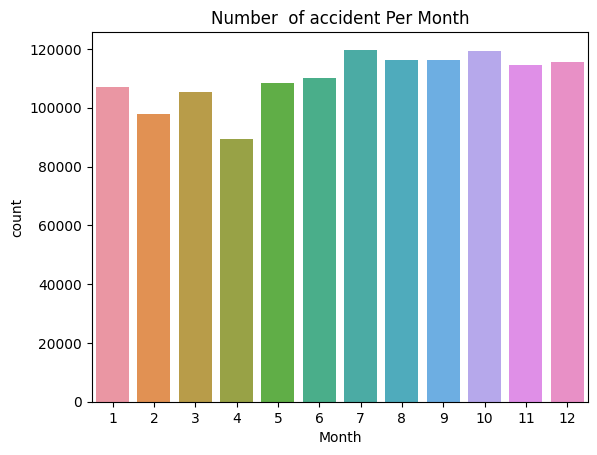

In [361]:
data = df.groupby(['Month'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of accident Per Month')
plt.ylabel('count');

Almost in all month we have similar number of accedent and the minimum accident mostly happend in April

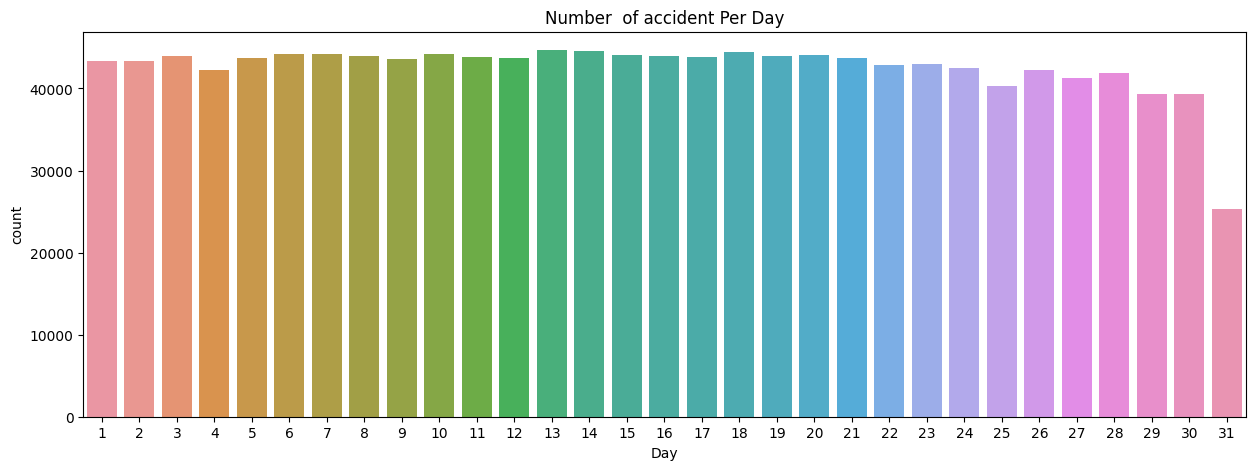

In [363]:
plt.figure(figsize=(15,5))
data = df.groupby(['Day'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of accident Per Day')
plt.ylabel('count');

The minimum accidents happend in 31th of each month

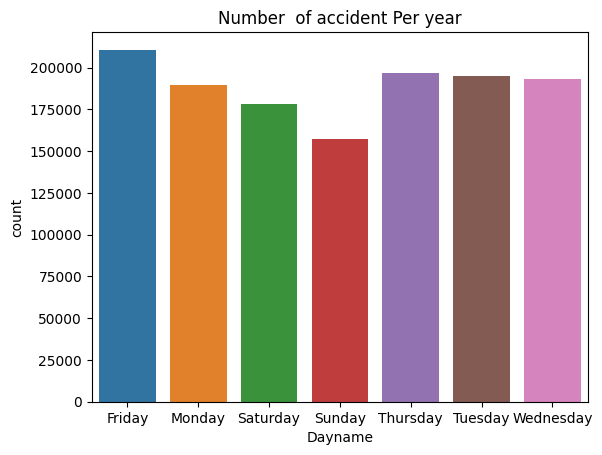

In [364]:
data = df.groupby(['Dayname'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of accident per year')
plt.ylabel('count');

on Sundays we have minimum number of accidents and Friday has the maximum number of accident

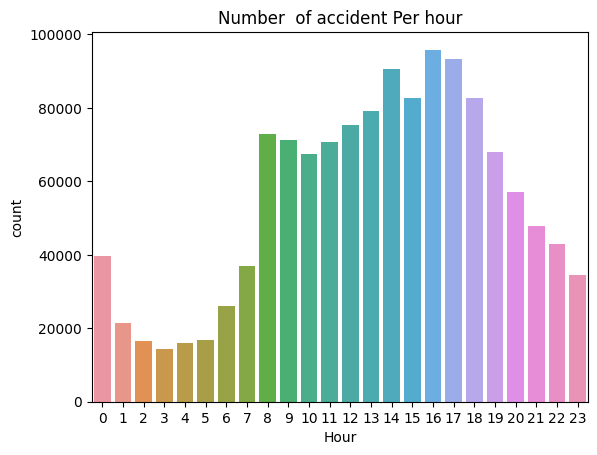

In [366]:
data = df.groupby(['Hour'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of accident Per hour')
plt.ylabel('count');

The lowest range of accident is between 1 to 6 am and the highest range of acceident is 14 to 18

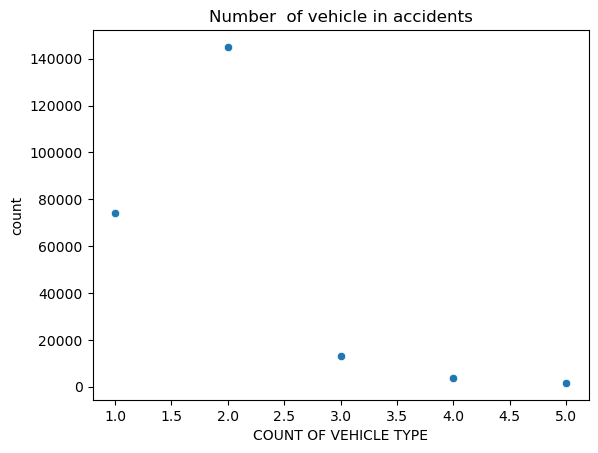

In [27]:
data = df.groupby(['COUNT OF VEHICLE TYPE'])['ZIP CODE'].count()
sns.scatterplot(x = data.index , y = data.values)
plt.title('Number  of vehicle in accidents')
plt.ylabel('count');

most of the acceident happend between two vehicles

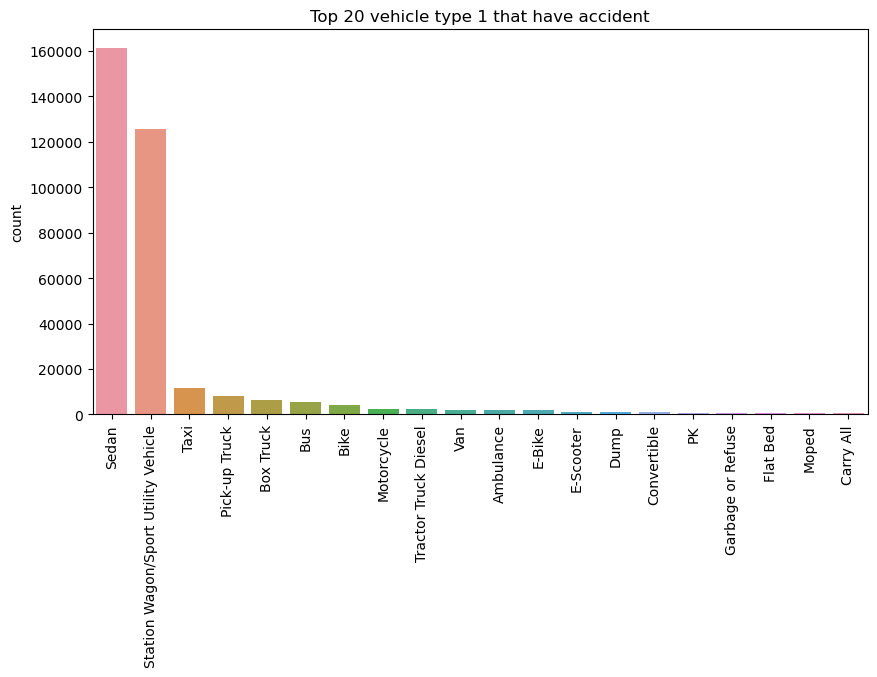

In [28]:
plt.figure(figsize=(10,5))
data = df['VEHICLE TYPE CODE 1'].value_counts(ascending = False)[:20]
sns.barplot(x = data.index , y = data.values)
plt.title('Top 20 vehicle type 1 that have accident')
plt.xticks(rotation = 90)
plt.ylabel('count');

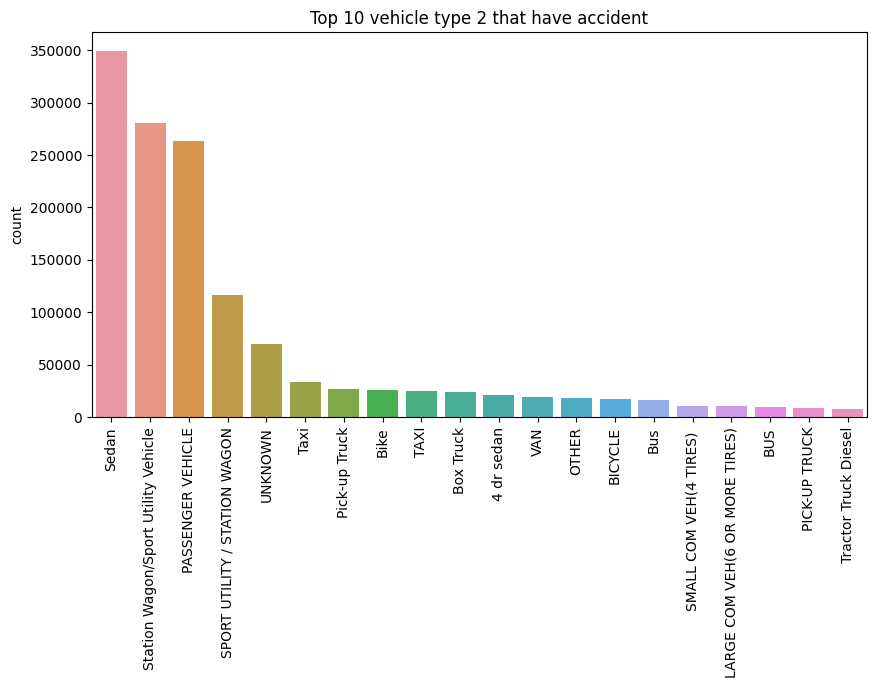

In [381]:
plt.figure(figsize=(10,5))
data = df['VEHICLE TYPE CODE 2'].value_counts(ascending = False)[:20]
sns.barplot(x = data.index , y = data.values)
plt.title('Top 10 vehicle type 2 that have accident')
plt.xticks(rotation = 90)
plt.ylabel('count');

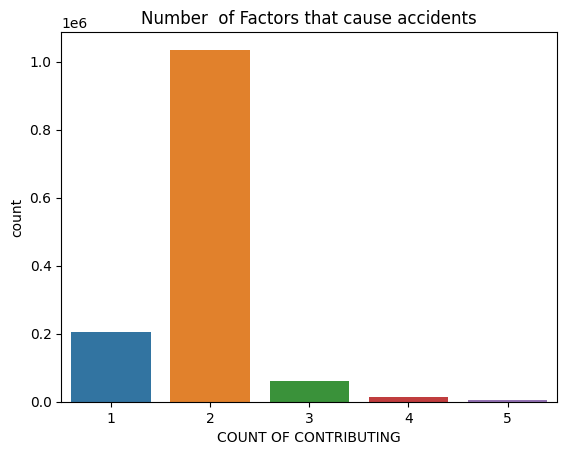

In [384]:
data = df.groupby(['COUNT OF CONTRIBUTING'])['ZIP CODE'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of Factors that cause accidents')
plt.ylabel('count');

most of the time there is 2 factors

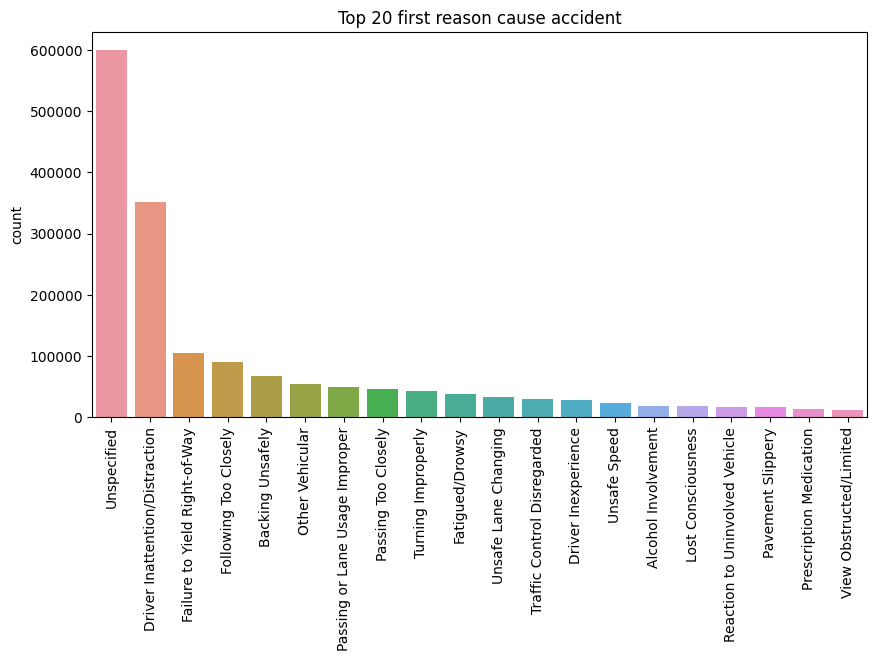

In [387]:
plt.figure(figsize=(10,5))
data = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts(ascending = False)[:20]
sns.barplot(x = data.index , y = data.values)
plt.title('Top 20 first reason cause accident')
plt.xticks(rotation = 90)
plt.ylabel('count');

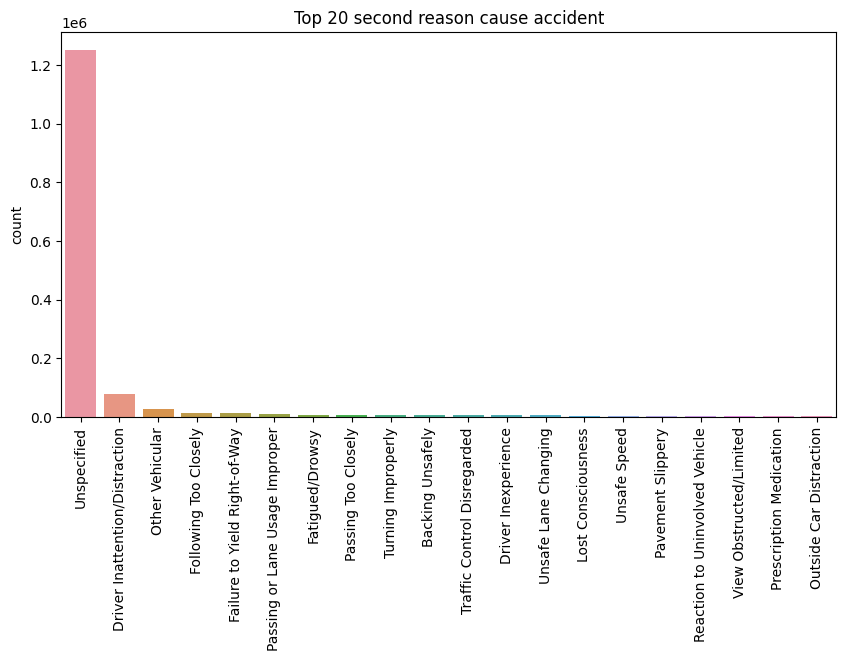

In [388]:
plt.figure(figsize=(10,5))
data = df['CONTRIBUTING FACTOR VEHICLE 2'].value_counts(ascending = False)[:20]
sns.barplot(x = data.index , y = data.values)
plt.title('Top 20 second reason cause accident')
plt.xticks(rotation = 90)
plt.ylabel('count');

- MOst of the time the reason of accident did not mentioned
- driver inattention is the most frequent reason that cause accident

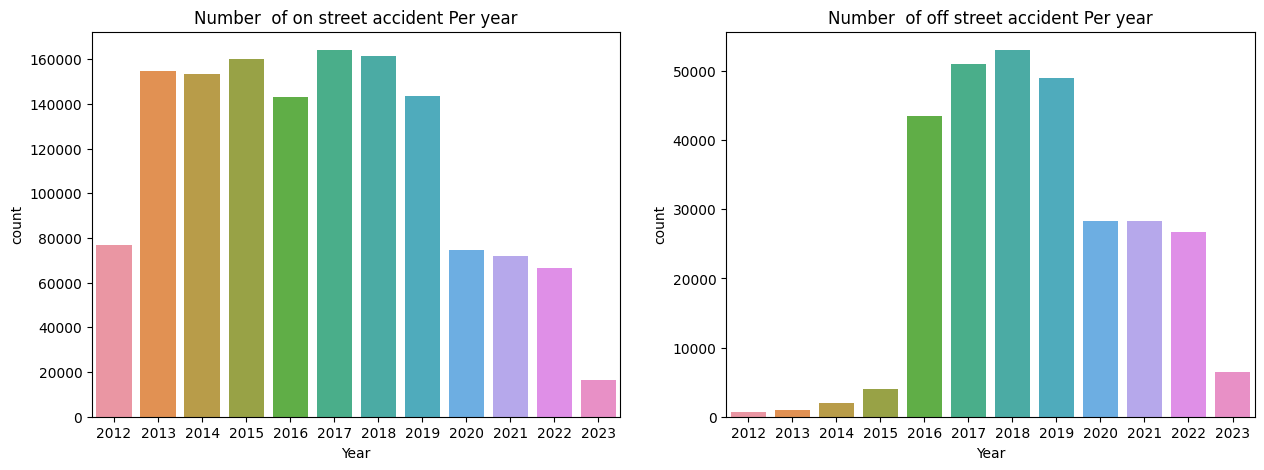

In [369]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data = df[df['ON STREET NAME']!= ''].groupby(['Year'])['ON STREET NAME'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of on street accident Per year')
plt.ylabel('count');

plt.subplot(1,2,2)
data = df[df['OFF STREET NAME']!= ''].groupby(['Year'])['OFF STREET NAME'].count()
sns.barplot(x = data.index , y = data.values)
plt.title('Number  of off street accident Per year')
plt.ylabel('count');

**Report**
- both number of off street and on street accident redude after 2019. 
- number of accident increse in off street aafter 2015 